<a href="https://colab.research.google.com/github/CRekkaran/Smart-Filter/blob/master/smiledetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Import and Install required Libraries

In [ ]:
import keras 
import numpy as np
import tensorflow as tf
import pandas as pd
from os import listdir
from os.path import isfile, join
import os
import random
import cv2
from google.colab.patches import cv2_imshow

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

!pip install git+git://github.com/PnS2019/pnslib.git
import matplotlib.pyplot as plt
from pnslib import utils

print(tf.config.experimental.list_physical_devices('GPU'))
tf.debugging.set_log_device_placement(True)

  Cloning git://github.com/PnS2019/pnslib.git to /tmp/pip-req-build-mt7kuuva
  Running command git clone -q git://github.com/PnS2019/pnslib.git /tmp/pip-req-build-mt7kuuva
  Created wheel for pnslib: filename=pnslib-0.1.0a1-cp36-none-any.whl size=1489618 sha256=0cf0b977f530d62f104c977a0cd6bde5a141e990f41d87f565be9df162250b9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-51lxv180/wheels/a2/8e/a9/c62e72840009deaa723b3a113d5c3b90acac77098d16e90eca
Successfully built pnslib
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
!git clone https://github.com/hromi/SMILEsmileD.git

Cloning into 'SMILEsmileD'...
remote: Enumerating objects: 13190, done.
remote: Total 13190 (delta 0), reused 0 (delta 0), pack-reused 13190
Receiving objects: 100% (13190/13190), 37.48 MiB | 18.07 MiB/s, done.
Resolving deltas: 100% (9/9), done.


In [ ]:
!mv ./SMILEsmileD/SMILEs ./
!mv ./SMILEs/negatives/smiles_01_neg.idx ./SMILEs/negatives/neglist.txt
!mv ./SMILEs/positives/smiles_01_pos.idx ./SMILEs/positives/poslist.txt

# 2. Training Data Refining

In [ ]:
path = './SMILEs/'

neg = [f for f in listdir(path+'negatives/negatives7') if isfile(join(path+'negatives/negatives7', f))]
pos = [f for f in listdir(path+'positives/positives7') if isfile(join(path+'positives/positives7', f))]

In [ ]:
neg = neg[:len(neg)//3]

In [ ]:
data = []
for i in range(len(pos)):
  im_ex = cv2.imread(path+'positives/positives7/'+pos[i])
  temp = im_ex
  data.append(([temp, 0]))


for i in range(len(neg)):
  im_ex = cv2.imread(path+'negatives/negatives7/'+neg[i])
  try:
    data.append(([im_ex, 1]))
  except:
    pass  
# print(len(data))
random.shuffle(data)

train_x = np.zeros(shape=(len(data), 64, 64, 3))
train_y = np.zeros(shape=(len(data),))
for i in range(len(data)):
  train_x[i] = np.array(data[i][0])
  train_y[i] = data[i][1]

In [ ]:
train_x = train_x.astype('float32')
train_y = (train_y).astype('float32')
train_x = train_x/255

n_samples = train_x.shape[0]
val_x = train_x[int(n_samples/5*4):]
train_x = train_x[:int(n_samples/5*4)]

val_y = train_y[int(n_samples/5*4):]
train_y = train_y[:int(n_samples/5*4)]



In [ ]:
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced'
#                                                ,np.unique(train_y)
#                                                ,train_y)

In [ ]:
train_y = keras.utils.to_categorical(train_y, 2)
val_y = keras.utils.to_categorical(val_y, 2)

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

for i in range(10):
  im_ex = cv2.imread(path+'positives/positives7/'+pos[i])
  print((im_ex[:,:,0]==im_ex[:,:,1]).any()==False)

False
False
False
False
False
False
False
False
False
False


# 3. Smile Detection: Model Atchitecture

In [ ]:
train_x.shape[1:]

(64, 64, 3)

In [ ]:
INPUT_SHAPE = (64, 64)
num_classes = 2
############################################################################################
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=train_x.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
# Let's train the model using RMSprop
model.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

model.summary()
############################################################################################

# model = Sequential()
# model.add(Conv2D(filters = 32, kernel_size = (3, 3), activation='relu', input_shape = (64, 64, 3) ))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.5))

# model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu'))
# model.add(BatchNormalization())
# model.add(MaxPooling2D(pool_size=2))
# model.add(Dropout(0.5))

# # model.add(Conv2D(filters = 32, kernel_size = (5, 5), activation='relu'))
# # model.add(BatchNormalization())
# # model.add(MaxPooling2D((3, 3)))
# # model.add(Dropout(0.5))

# model.add(Flatten())
# model.add(Dropout(0.5))
# model.add(Dense(32))
# model.add(Dense(2, activation='softmax'))

# model.compile(loss="binary_crossentropy", optimizer="sgd", metrics=["accuracy"])
# model.summary()

Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Executing op RandomUniform in device /job:localhost/replica:0/task:0/device:GPU:0
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
activation_56 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 62, 62, 32)        9248      
________________________

In [ ]:
BATCH_SIZE = 32
EPOCHS = 10

history = model.fit(train_x, train_y, batch_size=BATCH_SIZE, validation_data=(val_x, val_y), epochs=EPOCHS, shuffle=True)

Train on 5478 samples, validate on 1370 samples
Epoch 1/10
5478/5478 [==============================] - 3s 505us/step - loss: 0.2409 - accuracy: 0.9029 - val_loss: 0.2513 - val_accuracy: 0.8956
Epoch 2/10
5478/5478 [==============================] - 3s 507us/step - loss: 0.2365 - accuracy: 0.9058 - val_loss: 0.2381 - val_accuracy: 0.9080
Epoch 3/10
5478/5478 [==============================] - 3s 510us/step - loss: 0.2281 - accuracy: 0.9113 - val_loss: 0.2401 - val_accuracy: 0.9080
Epoch 4/10
5478/5478 [==============================] - 3s 495us/step - loss: 0.2239 - accuracy: 0.9135 - val_loss: 0.2899 - val_accuracy: 0.8832
Epoch 5/10
5478/5478 [==============================] - 3s 498us/step - loss: 0.2155 - accuracy: 0.9171 - val_loss: 0.2790 - val_accuracy: 0.8934
Epoch 6/10
5478/5478 [==============================] - 3s 507us/step - loss: 0.2064 - accuracy: 0.9241 - val_loss: 0.2373 - val_accuracy: 0.9036
Epoch 7/10
5478/5478 [==============================] - 3s 493us/step - loss

In [ ]:
history.history

# 4. Graph of Training Accuracy

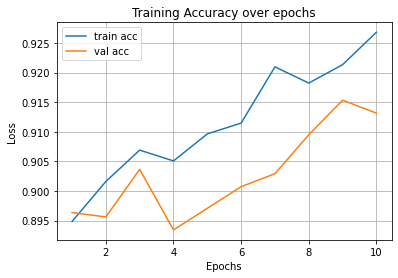

<Figure size 432x288 with 0 Axes>

In [ ]:
epochs = np.arange(10)+1
plt.title('Training Accuracy over epochs')
plt.plot(epochs, history.history['accuracy'], label='train acc')
plt.plot(epochs, history.history['val_accuracy'], label = 'val acc')
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.clf()

In [ ]:
epochs = np.arange(10)+1
plt.title('Training Loss over epochs')
plt.plot(epochs, history.history['loss'], label='train loss')
plt.plot(epochs, history.history['val_loss'], label = 'val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()
plt.clf()

# 5. Download Testing Images

In [ ]:
# !wget https://photos.google.com/share/AF1QipPVm40bX3p9R-n3xQoLj8BP_pXiPULMSZTTkzuH3oCqEq6Lf7eGhLW1UwIqia6UIg/photo/AF1QipN45xqWOXlRjG8rRW8BFRmRGGZzalmojQgw_D0?key=bzQyVW43VU9tZ2VvNWY4Y0Zpem5ydnNMN1EtczdB
# !wget https://lh3.googleusercontent.com/pw/ACtC-3eNkfsMa5xLjo_9zrtHgKZVqXuZjHtoRd6rDKruwzXMNx9BL8owYPYUwhWEDLBMuJlUx1Xp5ra2xfWGdMpGX-9LAc8J5zJqPhg3qRxxtl-GJzNGJPbzjlH5j39RfzmhyiyzhGxHB4cB0CB1p6Mby-fa=w493-h657-no?authuser=0
!wget https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F1166587487%2F960x0.jpg%3Ffit%3Dscale
!wget https://pe-images.s3.amazonaws.com/photo-editing/cc/smile/original.jpg
!wget https://image.freepik.com/free-photo/young-man-isolated-neutral-face_75922-474.jpg

# VGG Face

In [ ]:
!sudo pip install git+https://github.com/rcmalli/keras-vggface.git
import keras_vggface
# print version
print(keras_vggface.__version__)

In [ ]:
from keras_vggface.vggface import VGGFace
# create a vggface2 model
model = VGGFace(model='resnet50')
# summarize input and output shape
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

# 6. Testing phase - A Mess

[0 0 1 ... 0 0 0]


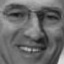

In [ ]:
print(model.predict_classes(train_x))
cv2_imshow(data[1][0])

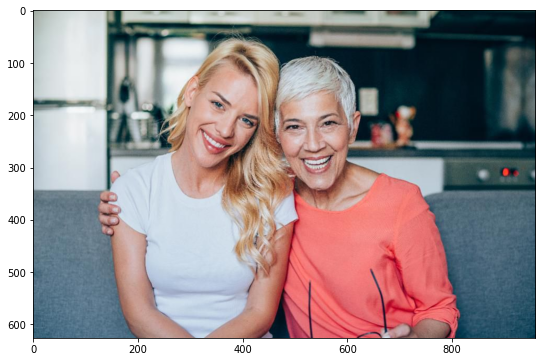

In [ ]:
# load in color image for face detection
image = cv2.imread('./1.jpg')
colored_im = np.copy(image)

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

orig_image = image.copy()

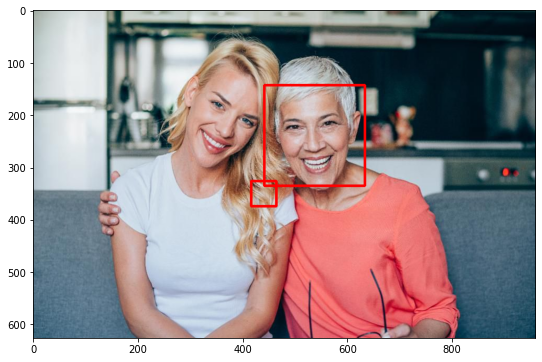

In [ ]:
import cv2
from pnslib import utils
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier(utils.get_haarcascade_path('haarcascade_frontalface_default.xml'))

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 2, 2)

image_with_detections = image.copy()

for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

In [ ]:
# TEXT SPECIFICATIONs
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (50,50)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

In [ ]:
image_copy = np.copy(image)

padding_w = 10
padding_h = 10

# Choosing the person with larger image area: so as to detect smile on only one person
max_w = 0
max_h = 0
max_x = 0
max_y = 0
for (x, y, w, h) in faces:
  if(w*h>max_w*max_h):
    max_w = w
    max_h = h
    max_x = x
    max_y = y

x, y, w, h = max_x, max_y, max_w, max_h

roi = image_copy[y-padding_h:y+h+padding_h, x-padding_w:x+w+padding_w]
print(roi.shape)    
image_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
image_gray=  image_gray/255.0

img = cv2.resize(image_gray, (64, 64))
temp = np.zeros(shape = (64, 64, 3))
for i in range(3):
  temp[:,:,i] = img

temp = temp.reshape(1, 64, 64, 3)
proba = model.predict(temp)

print(proba)

isSmiling = proba[0][0]>proba[0][1]
if isSmiling:
  textOnImage = 'Smiling'
else:
  textOnImage = 'Not Smiling'

cv2.putText(colored_im,textOnImage, 
    bottomLeftCornerOfText, 
    font, 
    fontScale,
    fontColor,
    lineType)
cv2_imshow(colored_im)


# 7. Function to label image based on smiling attribute

In [ ]:
# TEXT SPECIFICATIONs
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (50,50)
fontScale              = 1
fontColor              = (0,0,255)
lineType               = 2

In [ ]:
def detectSmileAndOutput(filename, param):
  image = cv2.imread(filename)
  colored_im = np.copy(image)

  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  face_cascade = cv2.CascadeClassifier(utils.get_haarcascade_path('haarcascade_frontalface_default.xml'))
  # FACE DETECTION
  # if necessary, modify these parameters until you successfully identify every face in a given image
  faces = face_cascade.detectMultiScale(image, param, 2)

  padding_w = 10
  padding_h = 10

  # Choosing the person with larger image area: so as to detect smile on only one person
  max_w = 0
  max_h = 0
  max_x = 0
  max_y = 0
  for (x, y, w, h) in faces:
    if(w*h>max_w*max_h):
      max_w = w
      max_h = h
      max_x = x
      max_y = y

  # BOUNDING BOX COORDINATES
  x, y, w, h = max_x, max_y, max_w, max_h

  roi = colored_im[y-padding_h:y+h+padding_h, x-padding_w:x+w+padding_w]
  image_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
  # NOW image_grey IS THE CROPPED IMAGE OF SINGLE HUMAN 8IN GRAYSCALE

  # PRE-PROCESSING INPUT IMAGE
  image_gray = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
  image_gray=  image_gray/255.0
  img = cv2.resize(image_gray, (64, 64))
  temp = np.zeros(shape = (64, 64, 3))
  for i in range(3):
    temp[:,:,i] = img

  temp = temp.reshape(1, 64, 64, 3)
  
  # PREDICTING USING TRAINED MODEL
  proba = model.predict(temp)

  print(proba)

  # ASSIGNING CLASS AND TEXT-ON-IMAGE
  isSmiling = proba[0][0]>proba[0][1]
  if isSmiling:
    textOnImage = 'Smiling: ' + str('%.2f' % proba[0][0])
  else:
    textOnImage = 'Not Smiling: ' + str('%.2f' % proba[0][1])

  # PUTTING TEXT ON IMAGE
  cv2.putText(colored_im,textOnImage, 
      bottomLeftCornerOfText, 
      font, 
      fontScale,
      fontColor,
      lineType)

  # PUTTING BOUNDING BOX ON IMAGE: BOX PREVIOUSLY CALCULATED USING CASCADE
  cv2.rectangle(colored_im,(x,y),(x+w,y+h),(255,0,0),3)

  # IMSHOW FINAL IMAGE WITH FACE AND SMILE DETECTION
  cv2_imshow(colored_im)

In [ ]:
# !wget https://image.freepik.com/free-photo/smiling-young-man-wearing-sunglasses-taking-selfie-showing-thumb-up-gesture_23-2148203116.jpg
# !wget https://c8.alamy.com/comp/X9HCNA/close-up-of-teenage-girls-smiling-face-X9HCNA.jpg
!wget https://c8.alamy.com/comp/G0ETRN/adorable-asian-girl-hands-cupping-face-smiling-G0ETRN.jpg

[[0.8043348  0.19566518]]


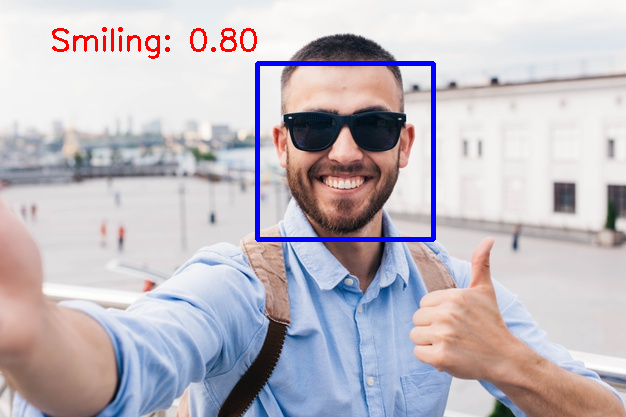

In [ ]:
detectSmileAndOutput('./selfie1.jpg', 1.2)

In [ ]:
model.save_weights('./smiledetection.h5')

In [ ]:
json_arch = model.to_json()

In [ ]:
json_arch

'{"class_name": "Sequential", "config": {"name": "sequential_2", "layers": [{"class_name": "Conv2D", "config": {"name": "conv2d_5", "trainable": true, "batch_input_shape": [null, 64, 64, 3], "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1, 1], "padding": "same", "data_format": "channels_last", "dilation_rate": [1, 1], "activation": "linear", "use_bias": true, "kernel_initializer": {"class_name": "VarianceScaling", "config": {"scale": 1.0, "mode": "fan_avg", "distribution": "uniform", "seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Activation", "config": {"name": "activation_56", "trainable": true, "dtype": "float32", "activation": "relu"}}, {"class_name": "Conv2D", "config": {"name": "conv2d_6", "trainable": true, "dtype": "float32", "filters": 32, "kernel_size": [3, 3], "strides": [1

# Testing Model Accuracy for left out data

In [ ]:
fax = [f for f in listdir(path+'negatives/negatives7') if isfile(join(path+'negatives/negatives7', f))]
datafax = []
for i in range(len(neg)):
  im_ex = cv2.imread(path+'negatives/negatives7/'+neg[i])
  try:
    datafax.append(([im_ex, 1]))
  except:
    pass  
# print(len(datafax))
random.shuffle(datafax)

train_x_fax = np.zeros(shape=(len(datafax), 64, 64, 3))
train_y_fax = np.zeros(shape=(len(datafax),))
for i in range(len(datafax)):
  train_x_fax[i] = np.array(datafax[i][0])
  train_y_fax[i] = datafax[i][1]

train_x_fax = train_x_fax.astype('float32')
train_y_fax = (train_y_fax).astype('float32')
train_x_fax = train_x_fax/255
train_y_fax = keras.utils.to_categorical(train_y_fax, 2)

score, accuracy = model.evaluate(train_x_fax, train_y_fax)
print('Score: %f, Accuracy: %f' % (score, accuracy))

3158/3158 [==============================] - 1s 169us/step
Score: 0.167022, Accuracy: 0.938569


# Camera Capture

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


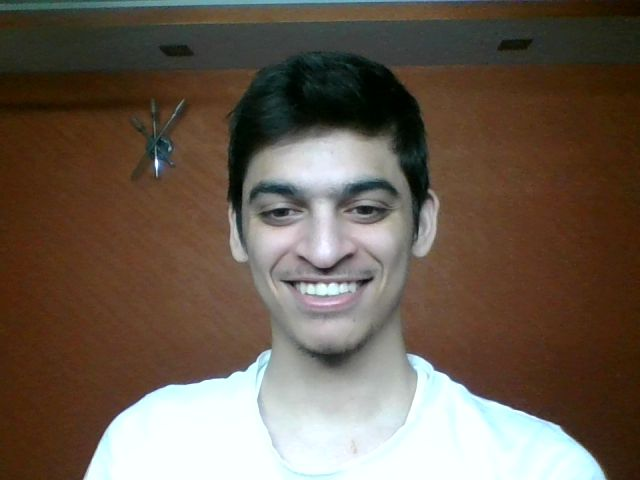

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))